<a href="https://colab.research.google.com/github/ebuehrle/tl-assoc/blob/main/tf2g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 51.3 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def rR(r1, r2):
  return np.array([
      [r1, -r2],
      [r2, r1]
  ])

In [ ]:
def rT(t1, t2):
  return np.array([t1, t2])

In [ ]:
X = 10*np.array([
	[0, 0],
	[0.5, 0.5],
	[0.25, 0.5],
	[1, 0],
	[1, 1],
])
X

array([[ 0. ,  0. ],
       [ 5. ,  5. ],
       [ 2.5,  5. ],
       [10. ,  0. ],
       [10. , 10. ]])

In [ ]:
Y = X @ rR(np.cos(0.1), np.sin(0.1)).T + rT(1., 0.5)
Y = np.concatenate([
    Y,
    5*np.array([
      [1.3, 0.5],
      [3, 3],
      [0, 2],
      [-1.3, -0.5],
      [0.9, 0.8],
      [2.1, 0],
      [0.01, -0.1],
    ])
], 0)
Y

array([[ 1.        ,  0.5       ],
       [ 5.47585374,  5.97418791],
       [ 2.98834333,  5.72460437],
       [10.95004165,  1.49833417],
       [ 9.95170749, 11.44837582],
       [ 6.5       ,  2.5       ],
       [15.        , 15.        ],
       [ 0.        , 10.        ],
       [-6.5       , -2.5       ],
       [ 4.5       ,  4.        ],
       [10.5       ,  0.        ],
       [ 0.05      , -0.5       ]])

In [ ]:
Y = np.array([[ 1.        ,  0.5       ],
       [ 5.47585374,  5.97418791],
       [ 2.98834333,  5.72460437],
       #[10.95004165,  1.49833417],
       [ 9.95170749, 11.44837582],
       [ 6.5       ,  2.5       ],
       [15.        , 15.        ],
       [ 0.        , 10.        ],
       [-6.5       , -2.5       ],
       [ 4.5       ,  4.        ],
       #[10.5       ,  0.        ],
       #[ 0.05      , -0.5       ]
       ])

In [ ]:
P = np.exp(-0.002*(X**2).sum(axis=1))
P

array([1.        , 0.90483742, 0.93941306, 0.81873075, 0.67032005])

In [ ]:
L2 = lambda A: sum(A[i, :] @ A[i, :] for i in range(A.shape[0]))
#JC = lambda R, T, S, N, X, Y: L2(X @ R.T + T.T - S @ Y - N * X)
JC = lambda R, T, S, N, X, Y: L2(X @ R.T + T.T - S @ Y - N)

In [ ]:
m = gp.Model("tf")

R = m.addMVar(shape=(2, 2), lb=-GRB.INFINITY)
T = m.addMVar(shape=(2, 1), lb=-GRB.INFINITY)
A = m.addMVar(shape=(X.shape[0], Y.shape[0] + 1), vtype=GRB.BINARY)
SB = A[:, :-1]
NB = A[:, -1:]
r1 = R[0, 0]
r2 = R[1, 0]

N = m.addMVar(shape=(X.shape[0], Y.shape[1]), lb=-GRB.INFINITY)
[m.addConstr((NB[i, 0] == 0) >> (N[i, j] == 0)) for i in range(NB.shape[0]) for j in range(Y.shape[1])]

#m.setObjective(JC(R, T, SB, N, X, Y) + 5*(r1 - 1)*(r1 - 1) + 5*r2*r2 + NB.T @ P, GRB.MINIMIZE)
m.setObjective(JC(R, T, SB, N, X, Y) + NB.T @ P, GRB.MINIMIZE)
[m.addConstr(sum(A[i, :]) == 1) for i in range(A.shape[0])]
[m.addConstr(sum(A[:, i]) <= 1) for i in range(A.shape[1]-1)]
m.addConstr(R[0, 0] == R[1, 1])
m.addConstr(R[0, 1] == -R[1, 0])

Restricted license - for non-production use only - expires 2024-10-28


<MConstr () *awaiting model update*>

In [ ]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 16 rows, 66 columns and 99 nonzeros
Model fingerprint: 0x73083f07
Model has 560 quadratic objective terms
Model has 10 general constraints
Variable types: 16 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 1e+00]
  QObjective range [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 16 rows, 66 columns, 99 nonzeros
Presolved model has 10 SOS constraint(s)
Presolved model has 560 quadratic objective terms
Variable types: 16 continuous, 50 integer (50 binary)
Found heuristic solution: objective 4.3333013

Root relaxation: objective 8.881784e-16, 49 iterations, 0.00 seconds (0.00 work units)



In [ ]:
R.X

array([[ 0.99500416, -0.09983342],
       [ 0.09983342,  0.99500416]])

In [ ]:
T.X

array([[1.        ],
       [0.50000001]])

In [ ]:
SB.X

array([[ 1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         9.99999998e-01,  1.01166779e-09, -0.00000000e+00,
         6.53951854e-10, -0.00000000e+00, -0.00000000e+00]])

In [ ]:
NB.X

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]])

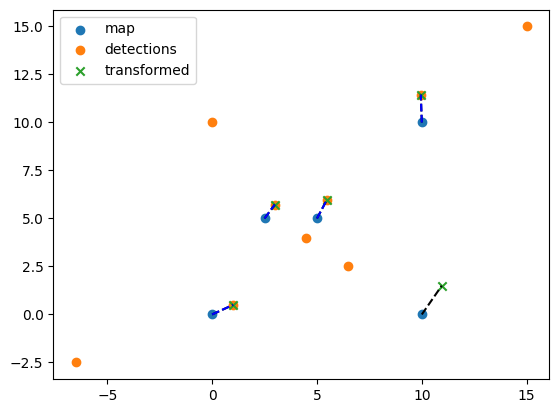

In [ ]:
XT = X @ R.X.T + T.X.T
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])
plt.scatter(XT[:,0], XT[:,1], marker='x')
plt.legend(("map", "detections", "transformed"))

P0 = X
P1 = XT
#P0 = P0[N.X==0, :]
#P1 = P1[N.X==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'k--'
)

P0 = X
P1 = SB.X @ Y
P0 = P0[NB.X.squeeze()==0, :]
P1 = P1[NB.X.squeeze()==0, :]
plt.plot(
  np.stack([P0[:,0], P1[:,0]], 1).T,
  np.stack([P0[:,1], P1[:,1]], 1).T,
  'b--'
)

plt.show()

In [ ]:
scale = np.sqrt(r1.X**2+r2.X**2)
scale

0.9999999986637949

In [ ]:
rotation = np.arctan2(r2.X, r1.X)
rotation

0.09999999948399042

In [ ]:
translation = T.X
translation

array([[1.        ],
       [0.50000001]])